## Packages + support code needed:

These include many of the familiar packages, and an excerpt from the pygeotools package, imported as individual functions thanks to David and Shashank. I am running this notebook on Windows, and because of some apparant problems with system paths to gdal in rasterio on Windows I also ran `from osgeo import gdal` as a work-around thanks to much advice and troubleshooting with Amanda.  

In [35]:
# Import packages
from osgeo import gdal 
import numpy as np
import rasterio as rio
from rasterio import plot, mask
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import xarray as xr
import rioxarray as rioxarray
import geopandas as gpd
import astropy as ap

In [36]:
#Compiled from pygeotools (dshean) and himat2cryo repositories
#given to me by Shashank

def checkma(a, fix=False):
    #isinstance(a, np.ma.MaskedArray)
    if np.ma.is_masked(a):
        out=a
    else:
        out=np.ma.array(a)
    #added to original code:
    return out

def maskfill(a, iterations=1, erode=False):
    import scipy.ndimage as ndimage 
    a = checkma(a)
    if erode:
        a = mask_islands(a, iterations)
    bmask = (~np.ma.getmaskarray(a))
    bmask_filled = ndimage.morphology.binary_fill_holes(bmask)
    #This will create valid values with a.filled in the original ma
    #a_erode.mask[:] = ~bmask_filled
    #return a_erode
    return ~bmask_filled

def gauss_fltr_astropy_fft(dem, size=None, sigma=None, origmask=False, fill_interior=False):
    
    """
    ***From pygeotools, commit to mainstream repo after full testing***
    # I use this over the direct Gaussian astropy filter  as it is way faster for large kernels
    Astropy gaussian filter properly handles convolution with NaN
    http://stackoverflow.com/questions/23832852/by-which-measures-should-i-set-the-size-of-my-gaussian-filter-in-matlab
    width1 = 3; sigma1 = (width1-1) / 6;
    Specify width for smallest feature of interest and determine sigma appropriately
    sigma is width of 1 std in pixels (not multiplier)
    scipy and astropy both use cutoff of 4*sigma on either side of kernel - 99.994%
    3*sigma on either side of kernel - 99.7%
    If sigma is specified, filter width will be a multiple of 8 times sigma 
    Alternatively, specify filter size, then compute sigma: sigma = (size - 1) / 8.
    If size is < the required width for 6-8 sigma, need to use different mode to create kernel
    mode 'oversample' and 'center' are essentially identical for sigma 1, but very different for sigma 0.3
    The sigma/size calculations below should work for non-integer sigma
    """

    #import astropy.nddata
    import astropy.convolution
    dem = checkma(dem)
    #Generate 2D gaussian kernel for input sigma and size
    #Default size is 8*sigma in x and y directions
    #kernel = astropy.nddata.make_kernel([size, size], sigma, 'gaussian')
    #Size must be odd
    if size is not None:
        size = int(np.floor(size/2)*2 + 1)
        size = max(size, 3)
    #Truncate the filter at this many standard deviations. Default is 4.0
    truncate = 3.0
    if size is not None and sigma is None:
        sigma = (size - 1) / (2*truncate)
    elif size is None and sigma is not None:
        #Round up to nearest odd int
        size = int(np.ceil((sigma * (2*truncate) + 1)/2)*2 - 1)
    elif size is None and sigma is None:
        #Use default parameters
        sigma = 1
        size = int(np.ceil((sigma * (2*truncate) + 1)/2)*2 - 1)
    size = max(size, 3)
    kernel = astropy.convolution.Gaussian2DKernel(sigma, x_size=size, y_size=size, mode='oversample')

    print("Applying gaussian smoothing filter with size %i and sigma %0.3f (sum %0.3f)" % \
            (size, sigma, kernel.array.sum()))

    #This will fill holes
    #np.nan is float
    #dem_filt_gauss = astropy.nddata.convolve(dem.astype(float).filled(np.nan), kernel, boundary='fill', fill_value=np.nan)
    #dem_filt_gauss = astropy.convolution.convolve(dem.astype(float).filled(np.nan), kernel, boundary='fill', fill_value=np.nan)
    #Added normalization to ensure filtered values are not brightened/darkened if kernelsum != 1
    dem_filt_gauss = astropy.convolution.convolve_fft(dem.astype(float).filled(np.nan), kernel, boundary='fill', 
                                                      fill_value=np.nan, normalize_kernel=True,
                                                     allow_huge=True)
    #This will preserve original ndv pixels, applying original mask after filtering
    if origmask:
        print("Applying original mask")
        #Allow filling of interior holes, but use original outer edge
        if fill_interior:
            mask = maskfill(dem)
        else:
            mask = dem.mask
        dem_filt_gauss = np.ma.array(dem_filt_gauss, mask=mask, fill_value=dem.fill_value)
    out = np.ma.fix_invalid(dem_filt_gauss, copy=False, fill_value=dem.fill_value)
    out.set_fill_value(dem.fill_value.astype(dem.dtype))
    return out.astype(dem.dtype), size

In [37]:
#Define diverging color-ramp used in entire notebook
#color = 'PiYG'#Pink and Green
color = 'RdBu'#Red and Blue
#color = 'RdYlGn' #Red and Green with yellow in middle

## Methods with code

### Loading data and adding overviews


In [38]:

fn_1 = '../KID13_data/manaster_20201109_KID13_5x_test_dsm.tif'
fn_2 = '../KID13_data/20220208_wittkopf2_KID13_dsm.tif'
fn_3 = '../MEL14_data/20220324_wittkopf3_MEL14_dsm.tif'
fn_5 = '../MEL14_data/20220428_wittkopf5_MEL14_dsm.tif'
fn_6 = '../MEL14_data/20220601_wittkopf_MEL14_dsm.tif'

Adding overviews using `gdaladdo` only needs to be done to a .tif once and some have them in their metadata already, so check whether overviews already exist and then uncomment code as needed. I've commented these out because they take a second to run, take up space in the notebook and I don't need them. 

In [39]:
#!gdalinfo $fn_2
#1 is dense resolution (use ov 2)
#2 is not dense (use full res)
#3 is not dense (use full res)
#5 is dense resolution (use ov 2)
#6 is not dense (use full res)

In [40]:
# !gdaladdo $fn_2

Next step is to use `rioxarray.open_rasterio().squeeze` with `overview_level = 2` and `mask_and_scale = True` specified. Overview 2 was chosen because it is the lowest resolution that doesn't have visible blocks of pixels for these data. During testing of this code this was convenient to run the functions faster. I also load a DataArray of the full resolution version here, which I will use for the remainder of this example 

In [45]:
#da_ov2_2 = rioxarray.open_rasterio(fn_2, overview_level = 2, mask_and_scale = True).squeeze()
#da_ov2_5 = rioxarray.open_rasterio(fn_5, overview_level = 2, mask_and_scale = True).squeeze()

da_full_1 = rioxarray.open_rasterio(fn_1, mask_and_scale= True).squeeze()
da_full_2 = rioxarray.open_rasterio(fn_2, mask_and_scale= True).squeeze()
da_full_3 = rioxarray.open_rasterio(fn_3, mask_and_scale = True).squeeze()
da_full_5 = rioxarray.open_rasterio(fn_5, mask_and_scale = True).squeeze()
da_full_6 = rioxarray.open_rasterio(fn_6, mask_and_scale = True).squeeze()

I'm also loading here a polygon shapefile drawn in QGIS according to the shape of the road. 

In [44]:
mask_path = '../MEL14_data/clip_shape.shp'
mask_gdf = gpd.read_file(mask_path)

### Clipping, Reprojecting and Matching
QUESTION: this is using cubic resampling right now, but in our meeting David mentioned bilinear, I'm not sure if that was an offhand comment of an example of a type of resampling or if that is the one I should use? Cubic seems to be the more thorough method and there's no problems with processing times so probably stick with that? API reference: https://rasterio.readthedocs.io/en/stable/api/rasterio.enums.html#rasterio.enums.Resampling 


In [46]:
#clipping using rioxarray
#be sure to specify desired resolution when calling the dataArray
da1_clipped = da_full_1.rio.clip(mask_gdf.geometry)
da2_clipped = da_full_2.rio.clip(mask_gdf.geometry)
da3_clipped = da_full_3.rio.clip(mask_gdf.geometry)
da5_clipped = da_full_5.rio.clip(mask_gdf.geometry)
da6_clipped = da_full_6.rio.clip(mask_gdf.geometry)

#reprojecting and matching
da2_clipped_proj = da2_clipped.rio.reproject_match(da1_clipped, resampling = 3)
da3_clipped_proj = da3_clipped.rio.reproject_match(da1_clipped, resampling = 3)
da5_clipped_proj = da5_clipped.rio.reproject_match(da1_clipped, resampling = 3)
da6_clipped_proj = da6_clipped.rio.reproject_match(da1_clipped, resampling = 3)

da_extent = da2_clipped_proj.rio.bounds()

### Differencing

After two datasets have been loaded and reprojected to match abitrary coordinate systems, they can be differenced and plotted.

In [47]:
diff1_2 = da2_clipped_proj - da1_clipped
diff2_3 = da3_clipped_proj -da2_clipped_proj
diff3_5 = da5_clipped_proj - da3_clipped_proj
diff5_6 = da6_clipped_proj - da5_clipped_proj

### High-pass Gaussian filtering

This is where the high-pass filter shines, allowing me to take another difference that eliminates the noise seen in the other difference. 

In [48]:
#This controls width of gaussian kernel standard deviation in pixels
#50 chosen for full resolution
#10 for overview 2
sigma = 75
diff_smooth1_2, size = gauss_fltr_astropy_fft(diff1_2, sigma = sigma)
diff_smooth2_3, size = gauss_fltr_astropy_fft(diff2_3, sigma = sigma)
diff_smooth3_5, size = gauss_fltr_astropy_fft(diff3_5, sigma = sigma)
diff_smooth5_6, size = gauss_fltr_astropy_fft(diff5_6, sigma = sigma)

Applying gaussian smoothing filter with size 451 and sigma 75.000 (sum 0.995)
Applying gaussian smoothing filter with size 451 and sigma 75.000 (sum 0.995)
Applying gaussian smoothing filter with size 451 and sigma 75.000 (sum 0.995)
Applying gaussian smoothing filter with size 451 and sigma 75.000 (sum 0.995)


In [49]:
diff_hp1_2 = diff1_2 - diff_smooth1_2
diff_hp2_3 = diff2_3 - diff_smooth2_3
diff_hp3_5 = diff3_5 - diff_smooth3_5
diff_hp5_6 = diff5_6 - diff_smooth5_6

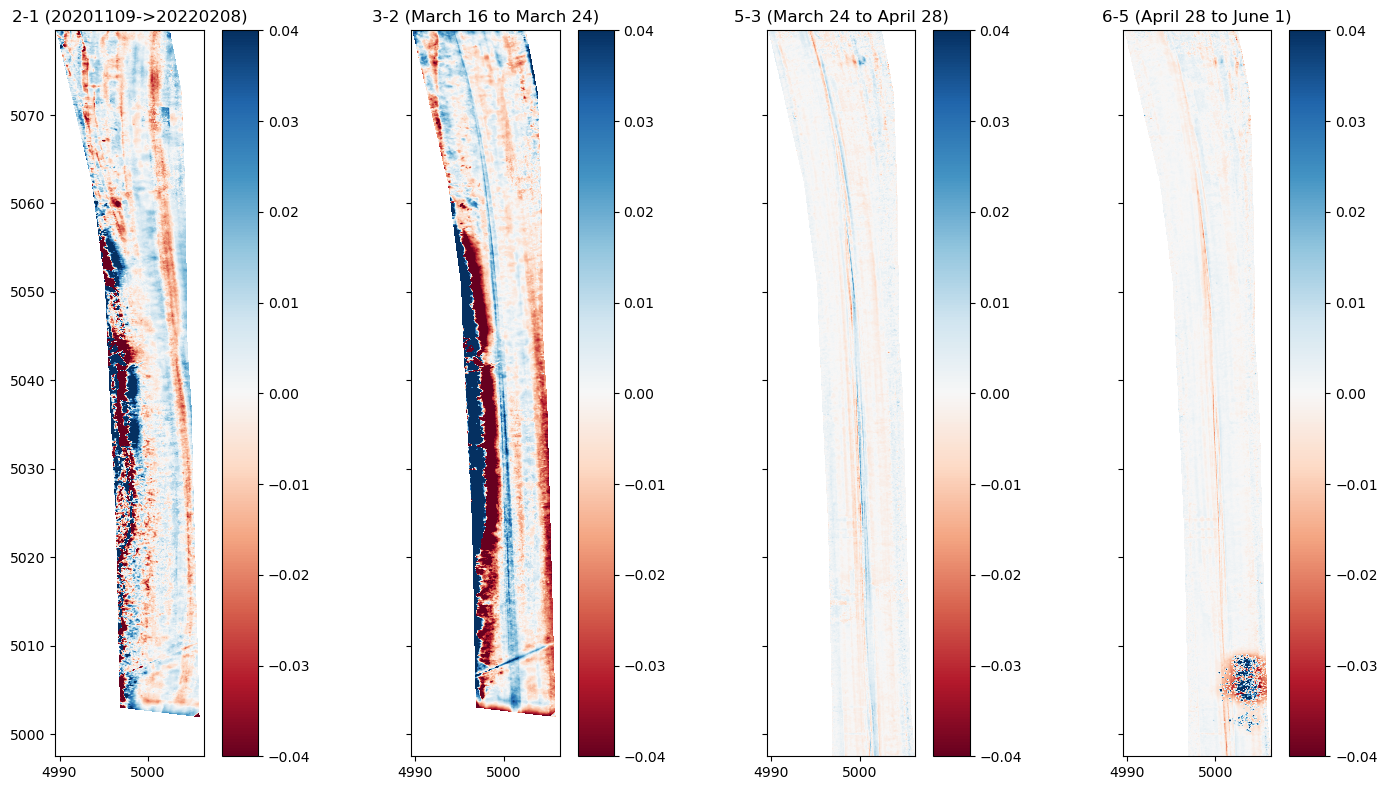

In [50]:
vmin= -0.04
vmax= 0.04

f, axa = plt.subplots(1,4, sharex=True, sharey=True, figsize=(15,8))

m = axa[0].imshow(diff_hp1_2, cmap = color , vmin = vmin, vmax = vmax, extent = da_extent)
f.colorbar(m, ax=axa[0])
axa[0].set_title("2-1 (20201109->20220208)")

m = axa[1].imshow(diff_hp2_3, cmap = color, vmin = vmin, vmax = vmax, extent = da_extent)
f.colorbar(m, ax=axa[1])
axa[1].set_title("3-2 (March 16 to March 24)")

m = axa[2].imshow(diff_hp3_5, cmap = color, vmin = vmin, vmax = vmax, extent = da_extent)
f.colorbar(m, ax=axa[2])
axa[2].set_title("5-3 (March 24 to April 28)")
    
m = axa[3].imshow(diff_hp5_6 , cmap=color, vmin=vmin, vmax=vmax, extent = da_extent)
f.colorbar(m, ax=axa[3])
axa[3].set_title("6-5 (April 28 to June 1)")
plt.savefig('high-pass filter attempt 2, on diff.png', bbox_inches='tight', dpi=300)
plt.tight_layout()

And we can zoom into A and B:

### Longitudinal plot along road
Below is a plot of longitudinal profiles taken across the x-axis of the road, with a step of 0.5 meters. Only those longitudinal profiles that have valid data during most of the length of the road are included here. From this plot we can see that across the road there is a wave occuring that we need to flatten to see more signal and less noise. 

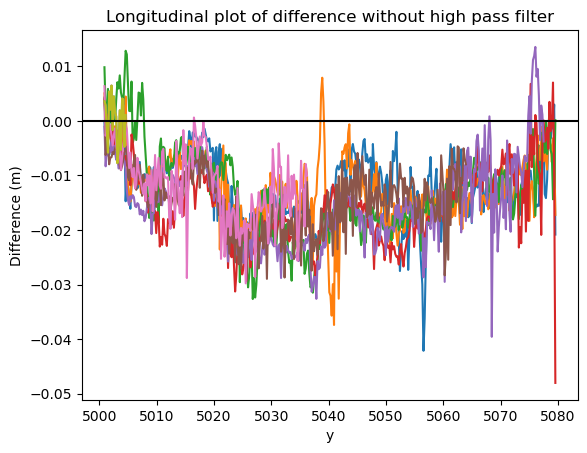

In [44]:
x = np.arange(4994, 4998.5, 0.5)

f, axa = plt.subplots()
ims = []
for i in x:
    ims.append(diff.sel(x=i, method='nearest').plot(ax=axa))
axa.axhline(0, color='k')
axa.set_ylabel('Difference (m)')
axa.set_title('Longitudinal plot of difference without high pass filter')
#attempt to animate but this is all it will show me
# anim = animation.ArtistAnimation(f, ims, interval=2000, repeat_delay=1000)
plt.show()

In [58]:
#This controls width of gaussian kernel standard deviation in pixels
#50 chosen for full resolution
#10 for overview 2
sigma = 8

diff_ma_smooth, size = gauss_fltr_astropy_fft(diff, sigma = sigma)

Applying gaussian smoothing filter with size 49 and sigma 8.000 (sum 0.996)


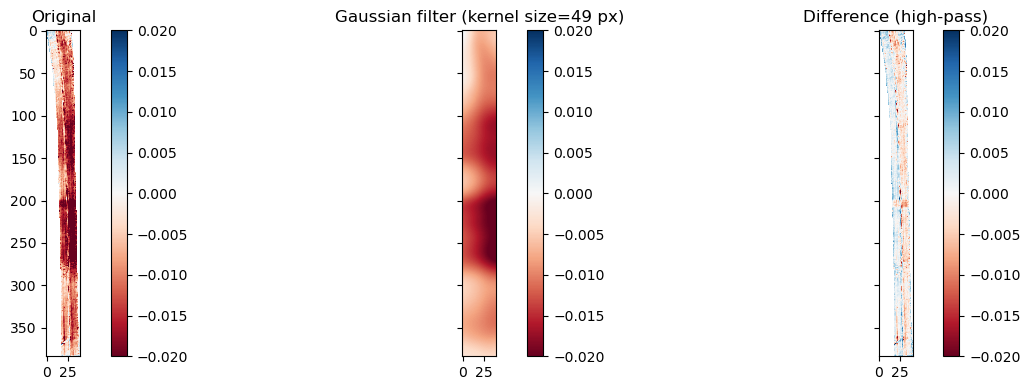

In [59]:
f, axa = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,4))
m = axa[0].imshow(diff, cmap = color , vmin = vmin, vmax = vmax)
f.colorbar(m, ax=axa[0])
axa[0].set_title("Original")
m = axa[1].imshow(diff_ma_smooth, cmap = color, vmin = vmin, vmax = vmax)
f.colorbar(m, ax=axa[1])
axa[1].set_title("Gaussian filter (kernel size=%s px)" % size)
diff_hp = diff - diff_ma_smooth

#resetting vmin and max for new difference values
values = pd.DataFrame(diff_hp.values).mean(1)
vmax_hp = 2*values.max()
vmin_hp = 2*values.min()
    
m = axa[2].imshow(diff_hp , cmap=color, vmin=vmin, vmax=vmax)
f.colorbar(m, ax=axa[2])
axa[2].set_title("Difference (high-pass)")
#plt.savefig('high-pass filter attempt 2, on diff.png', bbox_inches='tight', dpi=300)
plt.tight_layout()

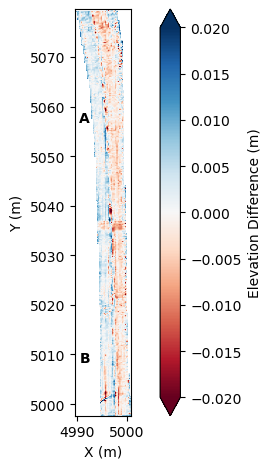

In [60]:
f, ax = plt.subplots()
plt.imshow(diff_hp, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)
plt.colorbar(label='Elevation Difference (m)', extend='both')

b_spot = [0.175,0.16]
a_spot = [0.175, 0.75]

ax.text(b_spot[0],b_spot[1], 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
ax.text(a_spot[0],a_spot[1], 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

plt.tight_layout()
#plt.savefig('Difference_MEL_overview=2.png', bbox_inches='tight', dpi=300)
plt.show()

Now we can look at the same longitudinal plot on the difference after the high pass filter and see that the long wave-form has been flattened so that the differences are more uniformly distributed about 0. So much better!

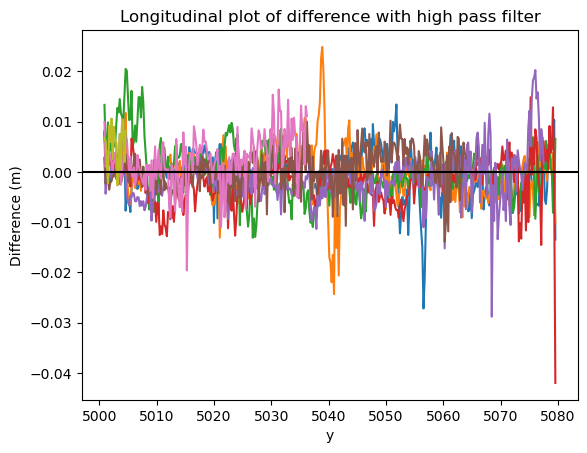

In [48]:
x = np.arange(4994, 4998.5, 0.5)

f, axa = plt.subplots()
ims = []
for i in x:
    ims.append(diff_hp.sel(x=i, method='nearest').plot(ax=axa))
axa.axhline(0, color='k')
axa.set_ylabel('Difference (m)')
axa.set_title('Longitudinal plot of difference with high pass filter')
#attempt to animate but this is all it will show me
# anim = animation.ArtistAnimation(f, ims, interval=2000, repeat_delay=1000)
plt.show()

We can also zoom in on those same areas and see a more meaningful result in micro-topographic feature resolution, with evenly formed ruts that aren't impacted by the road-long waveform

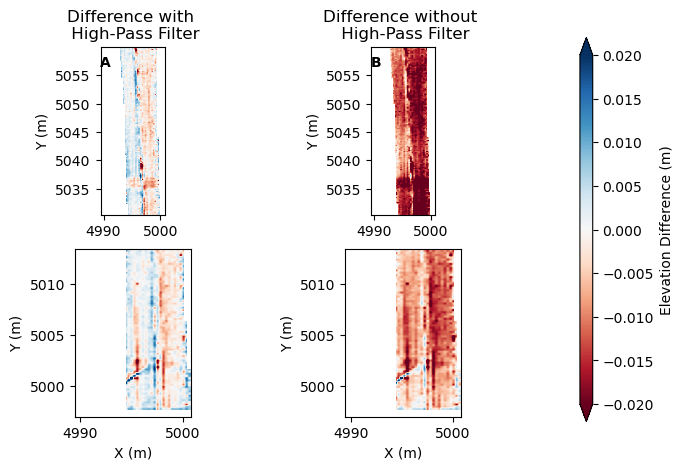

In [61]:
fig, axa = plt.subplots(nrows=2, ncols=2)

im1 = axa[0,0].imshow(diff_hp, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)
#axa[0,0].set_xlim(175,800)
axa[0,0].set_ylim(a_top, a_bottom)
axa[0,0].set_ylabel('Y (m)')
axa[0,0].set_title('Difference with \n High-Pass Filter')

im2 = axa[1,0].imshow(diff_hp, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)
#axa[1,0].set_xlim(320,850)
axa[1,0].set_ylim(b_bottom,b_top)
axa[1,0].set_xlabel('X (m)')
axa[1,0].set_ylabel('Y (m)')

im3 = axa[0,1].imshow(diff, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)
#axa[0,1].set_xlim(175,800)
axa[0,1].set_ylim(a_top, a_bottom)
axa[0,1].set_ylabel('Y (m)')
axa[0,1].set_title('Difference without \n High-Pass Filter')

im4 = axa[1,1].imshow(diff, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)
#axa[1,1].set_xlim(320,850)
axa[1,1].set_ylim(b_bottom,b_top)
axa[1,1].set_xlabel('X (m)')
axa[1,1].set_ylabel('Y (m)')



cb_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im1, cax=cb_ax, label='Elevation Difference (m)', extend='both')

axa[0,0].text(0.07, 0.95, 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=axa[0,0].transAxes)
axa[0,1].text(0.07, 0.95, 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=axa[0,1].transAxes)

#fig.colorbar(ax=ax1,label='Elevation Difference (m)', extend='both')
#plt.tight_layout()
#plt.savefig('Difference_zoom.png', bbox_inches='tight', dpi=300)
plt.show()